In [1]:
import numpy as np
from astropy.constants import R_sun, M_sun, G, k_B, m_p
import astropy.units as u

from funcs.model import calculate_specific_flare_flux, calculate_angular_radius

def get_frac_area(radius):
    return np.sin(radius / 180 * np.pi / 2.)**2


import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 15}

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


# 10kK assumption

In [2]:
k_B

<<class 'astropy.constants.codata2018.CODATA2018'> name='Boltzmann constant' value=1.380649e-23 uncertainty=0.0 unit='J / K' reference='CODATA 2018'>

In [3]:
calculate_specific_flare_flux("TESS", flaret=7e3)

<Quantity 3.57701096e+10 erg / (cm2 s)>

In [4]:
a = 1.
qlum = 1e29 * u.erg / u.s
R = .5 * R_sun
Teff = np.linspace(5e3,5e4,20)
Fth = [calculate_specific_flare_flux("TESS", flaret=t) for t in Teff]
radius = [calculate_angular_radius(fth, a, qlum, R) for fth in Fth]
fill_factor = get_frac_area(np.array(radius)) * 4.

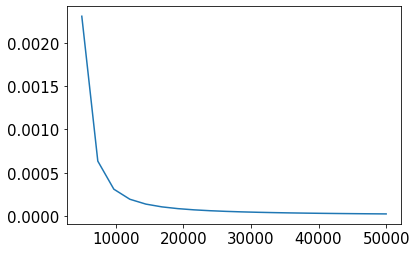

In [5]:
plt.plot(Teff, fill_factor)
#plt.yscale("log")

In [6]:
fill_factor

array([2.31087928e-03, 6.33670568e-04, 3.08814278e-04, 1.92164945e-04,
       1.35977478e-04, 1.03931929e-04, 8.35604071e-05, 6.96014625e-05,
       5.94993948e-05, 5.18794461e-05, 4.59426404e-05, 4.11956193e-05,
       3.73185269e-05, 3.40955297e-05, 3.13760390e-05, 2.90519726e-05,
       2.70438507e-05, 2.52919845e-05, 2.37507160e-05, 2.23845484e-05])

In [27]:
(1e-7 / u.s * np.pi * 2).to("1/d")

<Quantity 0.05428672 1 / d>

In [28]:
2piR/P = vsini / sin i

sin i = vsini * P / 2piR

SyntaxError: invalid syntax (<ipython-input-28-b2ec6745cc59>, line 1)

# back of the envelope calculation: pressure scale height

In [25]:
M = 0.16
Teff = 3030. * u.K
R =  0.199
g = G * (M * M_sun) / (R * R_sun)**2

In [26]:
H = k_B * Teff / (m_p * g)

In [27]:
H.decompose()

<Quantity 22575.98298498 m>

In [19]:
H.decompose()

<Quantity 13837.89950645 m>

In [20]:
13.8 / 180. #M6

0.07666666666666667

In [24]:
9.5 / 180. #L1

0.05277777777777778

In [28]:
22.6 / 180. #M5

0.12555555555555556

The pressure scale heights of the stars in our sample are about $5-13 \%$ of the solar

In [32]:
print(22.6 / (.199 * R_sun), 9.5 / (.107 * R_sun), 180. / (1. * R_sun) )

1.6324254591918916e-07 1 / m 1.2761973081640357e-07 1 / m 2.58732212160414e-07 1 / m


In [36]:
1.63 / 2.59, 1.28/2.59

(0.6293436293436293, 0.4942084942084942)

The relative height of atmospheres on M5-L1 dwarfs is $50-63\%$ percent of the relative solar height.

# latitude vs. flux

In [7]:
from altaipony.altai import equivalent_duration
from altaipony.flarelc import FlareLightCurve
import os
CWD = "/".join(os.getcwd().split("/")[:-2])
import pandas as pd


# Plot stuff
from funcs.model import full_model, aflare

In [8]:
# Datasets we analysed
datasets = [(100004076, "", "03_10_2020_11_27"),
            (237880881, "a", "03_10_2020_11_29"),
            (237880881, "b", "03_10_2020_11_29"),
            (277539431, "", "03_10_2020_11_30"),
             (44984200, "a", "04_08_2020_13_40"),
             (44984200, "b", "04_08_2020_13_40"),
             (44984200, "", "02_08_2020_17_44"),
            ]

In [9]:
res= pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv").loc[:6]
res.suffix = res.suffix.fillna("").astype(str)
vals = list(res.columns.values)
vals.remove("suffix")
vals.remove("tstamp")
vals.remove("color")
vals.remove("linestyle")
vals.remove("ID")
res[vals] = res[vals].astype(float) 

ID                             277539431
QCS                                   12
typ                                  slc
cadence_min                            2
mission                             tess
prefix                               TIC
origin                            custom
h_mission                           TESS
SpT                                   M7
view_start                          1641
view_stop                         1643.5
view_min                             750
view_max                             970
BJDoff                           2457000
tstart                           1641.84
ampl_min                             0.9
ampl_max                             1.7
GRP                                 1.52
plxmas                           72.9672
eplxmas                            0.569
RA                               163.815
Dec                             -73.9364
J                                  10.63
R                                    NaN
Gaia_G          

ID                     44984200
QCS                          10
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                   custom
h_mission                  TESS
SpT                          M6
view_start              1587.25
view_stop               1589.75
view_min                   1620
view_max                   2200
BJDoff                  2457000
tstart                  1588.03
ampl_min                    0.5
ampl_max                    0.8
GRP                        1.54
plxmas                  90.0357
eplxmas                0.222697
RA                      129.508
Dec                    -58.9331
J                        10.309
R                         15.08
Gaia_G                  14.4115
vsini_kms                  34.8
e_vsini_kms                 0.8
Prot_d                    0.113
sini                        NaN
Ref                   this work
identifier       SCR J0838-5855
Rstar   

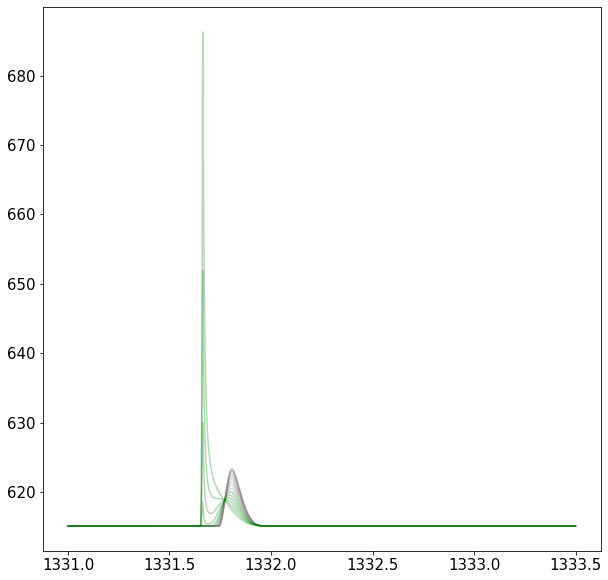

In [30]:
est = {}
plt.figure(figsize=(10,10))
for j, row in res.iterrows():
  
    # Get data
    #df = pd.read_csv(f"{CWD}/analysis/results/mcmc/{row.tstamp}_{row.ID}{row.suffix}_converted_mcmc_sample.csv")
    lc = pd.read_csv(f"{CWD}/data/lcs/{row.tstamp}_{row.ID}.csv")
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(row.ID)].iloc[0]
    print(target)
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    inits = inits[(inits.ID == str(row.ID)+row.suffix) & (inits.tstamp==row.tstamp)].iloc[0]

    qlum = inits.qlum_erg_s * u.erg / u.s
    Fth = inits.Fth * u.erg/ u.cm**2 / u.s
    median = inits['median']
    R = inits.R_Rsun * R_sun
    
     # Plot the results
    N = 50
    time = lc.t
    phi = lc.phi.values
    flux = lc.flux.values
    #inds = np.random.randint(df.shape[0], size=N)


    a = row.a_50
    phi_a = (row.t0_d_50 -lc.t[0]) / target.Prot_d * 2 * np.pi 
    #theta_a = row.latitude_deg_50 / 180 * np.pi
    fwhm = row.fwhm_d_50 / target.Prot_d * 2 * np.pi
    #i = row.i_deg_50 / 180 * np.pi
    i = np.pi/2

    phi0 = phi_a%(2.*np.pi) - (row.phase_deg_50  / 180 * np.pi)
    flare = aflare(phi, phi_a, fwhm, a*median)+ median
    print(f"ID: {row.ID}\n")
    est[str(row.ID) + row.suffix] = {}
    for theta_a in np.arange(5,85,5): 
        th = theta_a / 180. * np.pi
        fullmodel = full_model(phi_a, th, a, fwhm, i, phi0=phi0,
                               phi=phi, num_pts=50, qlum=qlum,
                               Fth=Fth, R=R, median=median)

        flc = FlareLightCurve(time=time, detrended_flux=fullmodel, )
        flc.it_med = np.full_like(time, median)
        ED = equivalent_duration(flc,0,-2)
        est[str(row.ID) + row.suffix][theta_a] = ED * qlum.value
        if (str(row.ID) == "237880881") & (str(row.suffix) == "a"):
            if theta_a > 50:
                c = "g"
            else:
                c = "grey"
            plt.plot(flc.time, flc.detrended_flux, c=c, alpha=.3)
            

In [21]:
# reform = {(outerKey, innerKey): values for outerKey, 
#           innerDict in est.items() for innerKey, 
#           values in innerDict.items()}
esti = pd.DataFrame(est)
esti

,277539431,237880881a,237880881b,44984200,44984200a,44984200b,100004076
5,9.458330e+33,8.943701e+32,6.701118e+33,6.621809e+32,4.040224e+32,1.005602e+32,8.933709e+31
10,9.353213e+33,8.840060e+32,6.621564e+33,6.546737e+32,3.994388e+32,9.941440e+31,8.831744e+31
15,9.172592e+33,8.740505e+32,6.494578e+33,6.422018e+32,3.918243e+32,9.751275e+31,8.662578e+31
20,8.931440e+33,8.540311e+32,6.324631e+33,6.248620e+32,3.812379e+32,9.486971e+31,8.427498e+31
25,8.641376e+33,8.251989e+32,6.093798e+33,6.027884e+32,3.677598e+32,9.150540e+31,8.128294e+31
30,8.279903e+33,8.022928e+32,5.825057e+33,5.761475e+32,3.514949e+32,8.744546e+31,7.767244e+31
35,7.823325e+33,7.668661e+32,5.542365e+33,5.451464e+32,3.325680e+32,8.272095e+31,7.347099e+31
40,7.355397e+33,7.310452e+32,5.176620e+33,5.100225e+32,3.111257e+32,7.736784e+31,6.871070e+31
45,6.808756e+33,6.971382e+32,4.775717e+33,4.710485e+32,2.873375e+32,7.142695e+31,6.342784e+31
50,6.225837e+33,6.589341e+32,4.350143e+33,4.285298e+32,2.613864e+32,6.494384e+31,5.766264e+31


In [29]:
edf = esti.loc[[10,45,80]].T
edf["frac45"] = edf[45]/edf[10]
edf["frac80"] = edf[80]/edf[10]
np.array([edf.frac45.median(), edf.frac45.std(), edf.frac80.median(), edf.frac80.std()])*100.
edf

,10,45,80,frac45,frac80
277539431,9.353213e+33,6.808756e+33,2.498608e+33,0.727959,0.267139
237880881a,8.840060e+32,6.971382e+32,2.189505e+33,0.788612,2.476799
237880881b,6.621564e+33,4.775717e+33,1.482600e+33,0.721237,0.223905
44984200,6.546737e+32,4.710485e+32,1.215480e+32,0.719516,0.185662
44984200a,3.994388e+32,2.873375e+32,7.408579e+31,0.719353,0.185475
44984200b,9.941440e+31,7.142695e+31,1.773566e+31,0.718477,0.178401
100004076,8.831744e+31,6.342784e+31,1.564060e+31,0.718180,0.177095


2.4986075282280465e+33
237880881a
5.959983419163326e+32
3.435417793483967e+33
2.30403343543378e+32
44984200a
7.408578590326474e+31
1.7735655411059122e+31
6.342784292180893e+31


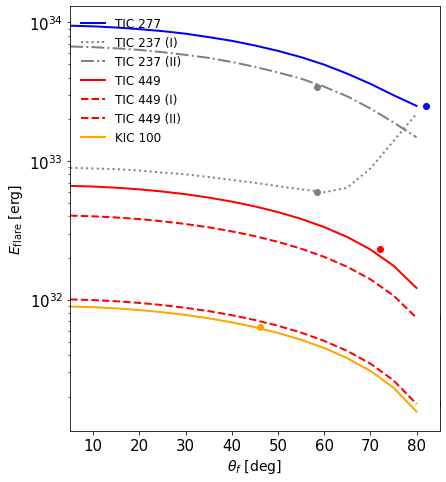

In [28]:
plt.figure(figsize=(6,6.5))
res.ID = res.ID.astype(str)
for col in esti:

    if "a" in col:
        print(col)
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "a")]
        suff = " (I)"
    elif "b" in col:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "b")]
        suff = " (II)"
      
    else:
        _ = res[(res.ID.str[:5] == col[:5]) & (res.suffix == "")]
        suff = ""
    c = _.iloc[0].color
    l = _.iloc[0].linestyle
    lab = str(props[props.ID == int(_.ID)].iloc[0].prefix) + " " +  _.iloc[0].ID[:3] + suff
    plt.plot(esti.index, esti[col], color =c, label=lab, linestyle=l, linewidth=2)
    I = np.argmin(np.abs(esti.index.values - _.iloc[0].latitude_deg_50))
    en = esti.loc[esti.index[I], str(col)]
    print( esti.loc[esti.index[I], str(col)])
    plt.scatter(x=_.latitude_deg_50, y=en, c=c)

plt.legend(frameon=False, fontsize=12)
plt.xlim(5,85)
plt.yscale("log")
plt.tight_layout()
# plt.ylabel(r"$ED$ [s]", fontsize=14)
plt.ylabel(r"$E_\mathrm{flare}$ [erg]", fontsize=14)

plt.xlabel(r"$\theta_f$ [deg]", fontsize=14);

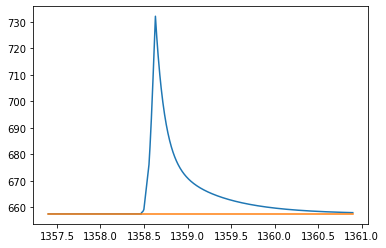

In [84]:
plt.plot(flc.time, flc.detrended_flux)
plt.plot(flc.time, flc.it_med)

In [85]:
equivalent_duration(flc,0,-4)

2868.7908427679163

In [54]:
len(time)

891

In [109]:
row.ID

'100004076'

# Inclinations from Elisabeth

In [161]:
incl = pd.read_csv(f"{CWD}/data/inclinations/inclination_output.dat", delimiter=r"\s+")
incl

,prefix,id,inclination,inclination_lowerr,inclination_uperr
0,KIC,100004076,58.592186,-13.990519,18.499819
1,TIC,237880881,22.210949,-3.943153,4.006488
2,TIC,44984200,33.159762,-0.868109,0.838674
3,TIC,277539431,82.895193,-5.781124,4.903759


In [31]:
2.1e34/5e32

42.00000000000001